# Autoencoder - on the MNIST dataset:

The following is an illustration/exercise in using an Auto-Encoder on image data. The general idea is, that if one can encode (i.e. represent with "few" parameters) images, and then from this encoding decode them again to obtain "almost" the same images, then the few parameters (in a latent space) contains the basic information about the images.

![](AutoEncoder.png "")

An AutoEncoder is trained by requiring that the output images match the input images *best possible*, which is (of course) represented by a loss function. Thus, **an AutoEncoder does not require labels**, and is as such unsupervised learning. The power lies in that one gets a good representation of the data through the latent space (the size of which you can choose) for essentially any NN-based method, here a CNN.

This can then be used (aggresively!) for many things such as:
* Compression (with loss!) of the images (to the size of the latent space)
* De-noising images
* Anomaly detection
* Unsupervised learning (e.g. clustering) on images, sound, graphs, etc.

In the example at hand, we consider the MNIST dataset (28x28 (=784) images of digits), and autoencode these images into a latent space of size 4. We then project this latent space onto just two dimensions using UMAP, and see if we (or a clustering algorithm) can detect clusters and possibly determine how many digits there are... *without ever having known anything about arabic numerals!!!*

***

Authors: Amalie Mygind and Troels Petersen (based on example from Medium)<br>
Date: 14th of May 2023 (latest version)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import random 

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from umap import UMAP

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import itertools

c:\Users\Simon Andersen\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load the training and test datasets
train_dataset = datasets.MNIST('dataset', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('dataset', train=False, download=True, transform=transform)

In [3]:
# Split training data into training and validation data:
full_len = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(full_len-full_len*0.2), int(full_len*0.2)])
batch_size=256

In [30]:
len(train_data), len(val_data), len(test_dataset)

(48000, 12000, 10000)

### Question - do we need to split the data?

We somehow always split the data into these three datasets, but given that we are doing unsupervised learning here, try to think about the degree to which we need to divide the data in this way.

In [4]:
# Create PyTorch dataloaders for data:
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [ ]:
# Define the autoencoder model (explained in comments below):

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section:
        # So we decide to take our 1 input image and first apply 8 kernels/filters of size 3x3
        # with a stride (i.e. step size) of 2 and padding the edge with one layer.
        # This output goes through a ReLU and then through 16 new kernels/filters
        # of the same size, stride and padding, which is then BatchNorm'ed, ReLU'ed, and finally
        # convoluted a third time, again doubling the number of kernels/filters (quite standard!).
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        # The images/matrices are then flatten'ed (put into one long array), put through a linear layer,
        # then a ReLU, and then finally another linear layer, which boils it down to the latent space
        # dimension.
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### The decoder does the exact opposite, reconstructing the images from the latent space values.
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [22]:
# simon's generalized version of the above autoencoder:

class Encoder(nn.Module):
    def __init__(
        self,
        encoded_space_dim: int,
        input_channels: int = 1,
        input_size: tuple[int, int] = (28, 28),
        conv_channels: list[int] = [8, 16, 32],
        kernel_sizes: list[int] = [3, 3, 3],
        strides: list[int] = [2, 2, 2],
        paddings: list[int] = [1, 1, 0],
        linear_dims: list[int] = [128],
        use_batchnorm: bool = True,
        activation: nn.Module = nn.ReLU(True),
    ):
        super().__init__()

        assert len(conv_channels) == len(kernel_sizes) == len(strides) == len(paddings)

        # --- Convolutional layers ---
        layers = []
        in_ch = input_channels
        for out_ch, k, s, p in zip(conv_channels, kernel_sizes, strides, paddings):
            layers.append(nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(activation)
            in_ch = out_ch

        self.encoder_cnn = nn.Sequential(*layers)

        # --- Infer flatten shape automatically using dummy forward pass ---
        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, *input_size)
            conv_out = self.encoder_cnn(dummy)
            self._conv_output_shape = conv_out.shape[1:]  # (C, H, W)
            self._flattened_dim = int(torch.tensor(self._conv_output_shape).prod())

        # --- Linear layers ---
        fc_layers = []
        prev_dim = self._flattened_dim
        for dim in linear_dims:
            fc_layers.append(nn.Linear(prev_dim, dim))
            fc_layers.append(activation)
            prev_dim = dim
        fc_layers.append(nn.Linear(prev_dim, encoded_space_dim))
        self.encoder_lin = nn.Sequential(*fc_layers)

        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(
        self,
        encoded_space_dim: int,
        conv_output_shape: tuple[int, int, int],
        output_channels: int = 1,
        conv_channels: list[int] = [32, 16, 8],
        kernel_sizes: list[int] = [3, 3, 3],
        strides: list[int] = [2, 2, 2],
        paddings: list[int] = [0, 1, 1],
        output_paddings: list[int] = [0, 1, 1],
        linear_dims: list[int] = [128],
        use_batchnorm: bool = True,
        activation: nn.Module = nn.ReLU(True),
    ):
        super().__init__()

        # --- Linear section ---
        fc_layers = []
        prev_dim = encoded_space_dim
        for dim in linear_dims:
            fc_layers.append(nn.Linear(prev_dim, dim))
            fc_layers.append(activation)
            prev_dim = dim
        fc_layers.append(nn.Linear(prev_dim, int(torch.tensor(conv_output_shape).prod())))
        fc_layers.append(activation)
        self.decoder_lin = nn.Sequential(*fc_layers)

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_output_shape)

        # --- Transposed convs ---
        layers = []
        in_chs = conv_channels
        out_chs = conv_channels[1:] + [output_channels]
        for in_ch, out_ch, k, s, p, op in zip(in_chs, out_chs, kernel_sizes, strides, paddings, output_paddings):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, k, stride=s, padding=p, output_padding=op))
            if out_ch != output_channels:
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_ch))
                layers.append(activation)

        self.decoder_conv = nn.Sequential(*layers)

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


### Define training and validation functions:

### Training function
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer, device):
    encoder.train()
    decoder.train()
    train_loss = []

    for image_batch, _ in dataloader:
        # Move batch to device
        image_batch = image_batch.to(device)

        # Forward pass
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)

        # Compute loss
        loss = loss_fn(decoded_data, image_batch)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### Testing function
def test_epoch(encoder, decoder, dataloader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []

        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)

            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        val_loss = loss_fn(conc_out, conc_label)

    return val_loss.item()

### Plot reconstruction outputs
def plot_ae_outputs(encoder, decoder, test_dataset, device, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}

    encoder.eval()
    decoder.eval()

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)

        with torch.no_grad():
            rec_img = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')

    plt.show()



In [43]:
encoded_space_dim = 6
linear_dims = [128]

encoder_kwargs = {
    "encoded_space_dim": encoded_space_dim,
    "input_channels": 1,
    "conv_channels": [8, 16, 32],
    "kernel_sizes": [3, 3, 3],
    "strides": [2, 2, 2],
    "paddings": [1, 1, 0],
    "linear_dims": linear_dims,
    "use_batchnorm": True,
    "activation": nn.ReLU(True),
    }
decoder_kwargs = {
    "encoded_space_dim": encoded_space_dim,
    "output_channels": encoder_kwargs["input_channels"],
    "conv_channels": encoder_kwargs["conv_channels"][::-1],
    "kernel_sizes": encoder_kwargs["kernel_sizes"][::-1],
    "strides": encoder_kwargs["strides"][::-1],
    "paddings": encoder_kwargs["paddings"][::-1],
    "output_paddings": encoder_kwargs["paddings"][::-1],
    "linear_dims": encoder_kwargs["linear_dims"][::-1],
    "use_batchnorm": encoder_kwargs["use_batchnorm"],
    "activation": nn.ReLU(True),
    }

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

encoder = Encoder(input_size=(28, 28), **encoder_kwargs)
decoder = Decoder(conv_output_shape=encoder._conv_output_shape, **decoder_kwargs)

encoder.to(device)
decoder.to(device)

num_params_enc = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
num_params_dec = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print('Number of parameters in encoder: %d' % num_params_enc)
print('Number of parameters in decoder: %d' % num_params_dec)

# Define loss function and training parameters:

# Define the loss function
loss_fn = nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

# Set the random seed for reproducible results
torch.manual_seed(42)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

Using device: cuda
NVIDIA GeForce 940MX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of parameters in encoder: 43766
Number of parameters in decoder: 43953


### Question - what is the dimension of the latent space?

Ask yourself, how many dimensions we boild the images down to, i.e. how many numbers represent what the images look like?

NOTE: You may want to launch the training cell below (which takes a few minutes) and then think about the answer.


 EPOCH 1/30 	 train loss 0.11043691635131836 	 val loss 0.0618673712015152


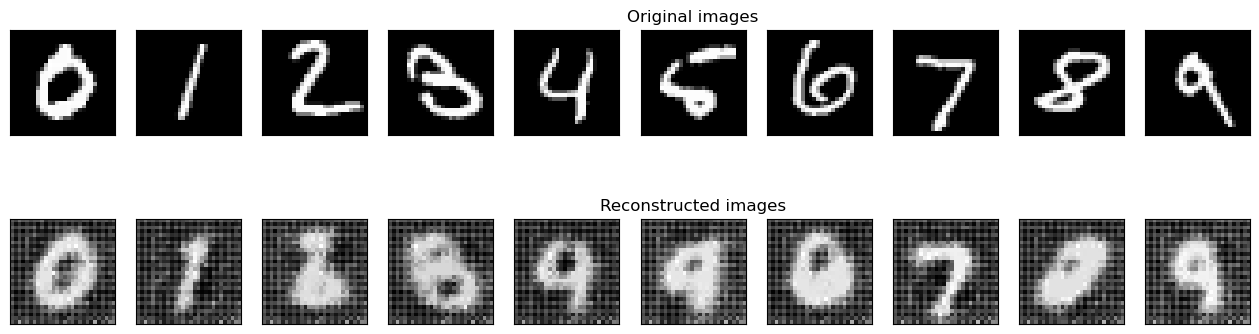


 EPOCH 2/30 	 train loss 0.05122453719377518 	 val loss 0.04575110226869583

 EPOCH 3/30 	 train loss 0.042435768991708755 	 val loss 0.04046822339296341

 EPOCH 4/30 	 train loss 0.03823034092783928 	 val loss 0.036795973777770996

 EPOCH 5/30 	 train loss 0.03484899550676346 	 val loss 0.03345745429396629

 EPOCH 6/30 	 train loss 0.031375110149383545 	 val loss 0.029082955792546272


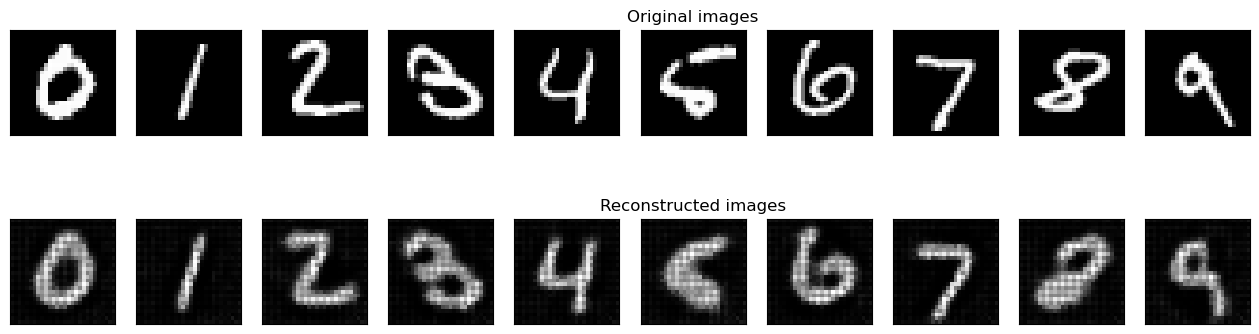


 EPOCH 7/30 	 train loss 0.026621129363775253 	 val loss 0.024526365101337433

 EPOCH 8/30 	 train loss 0.023745201528072357 	 val loss 0.022670593112707138

 EPOCH 9/30 	 train loss 0.022462917491793633 	 val loss 0.021789133548736572

 EPOCH 10/30 	 train loss 0.02173953875899315 	 val loss 0.021304752677679062

 EPOCH 11/30 	 train loss 0.021265478804707527 	 val loss 0.02104954794049263


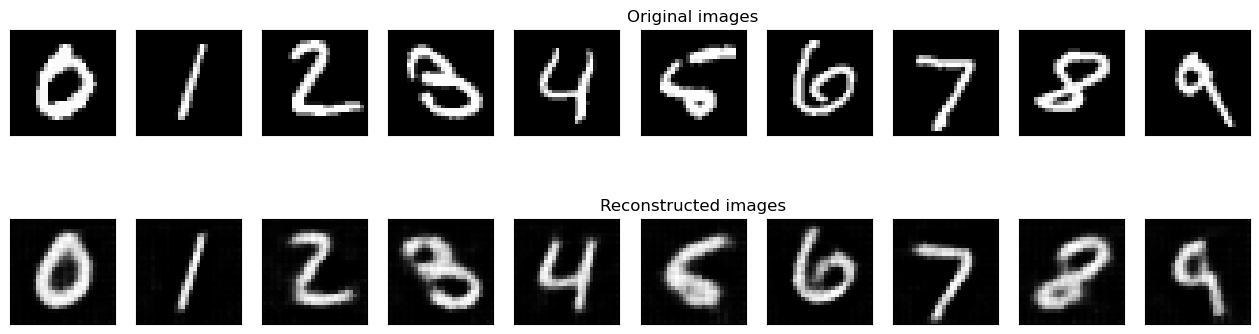


 EPOCH 12/30 	 train loss 0.02090187557041645 	 val loss 0.020799066871404648

 EPOCH 13/30 	 train loss 0.020604027435183525 	 val loss 0.020549817010760307

 EPOCH 14/30 	 train loss 0.020361747592687607 	 val loss 0.020313847810029984

 EPOCH 15/30 	 train loss 0.020152807235717773 	 val loss 0.02020762860774994

 EPOCH 16/30 	 train loss 0.019991859793663025 	 val loss 0.020073628053069115


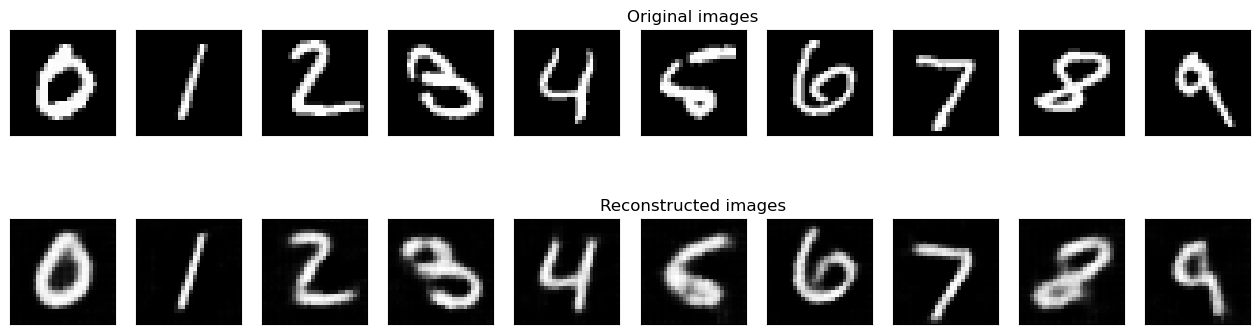


 EPOCH 17/30 	 train loss 0.019848590716719627 	 val loss 0.019959889352321625

 EPOCH 18/30 	 train loss 0.01973215490579605 	 val loss 0.019880469888448715

 EPOCH 19/30 	 train loss 0.01961524598300457 	 val loss 0.019761262461543083

 EPOCH 20/30 	 train loss 0.019503427669405937 	 val loss 0.019680462777614594

 EPOCH 21/30 	 train loss 0.019409948959946632 	 val loss 0.019602982327342033


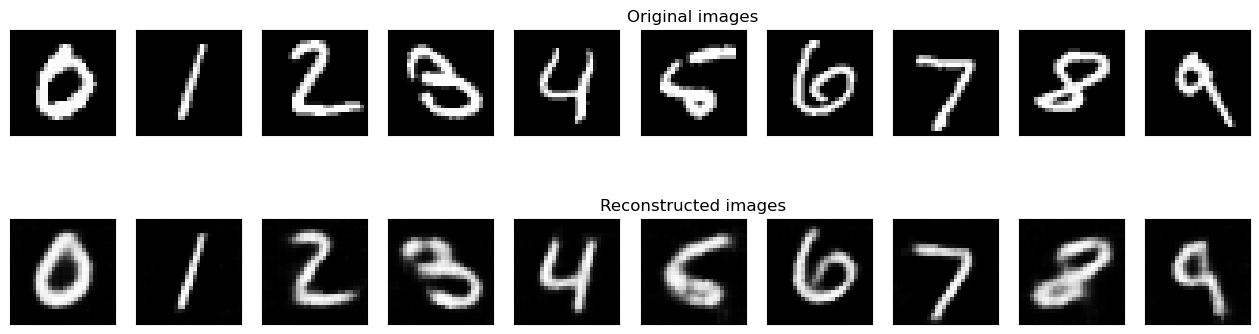


 EPOCH 22/30 	 train loss 0.019319428130984306 	 val loss 0.01954188384115696

 EPOCH 23/30 	 train loss 0.01923282817006111 	 val loss 0.019486568868160248

 EPOCH 24/30 	 train loss 0.019165178760886192 	 val loss 0.01943846605718136

 EPOCH 25/30 	 train loss 0.019104383885860443 	 val loss 0.01937132142484188

 EPOCH 26/30 	 train loss 0.019046979025006294 	 val loss 0.01930898427963257


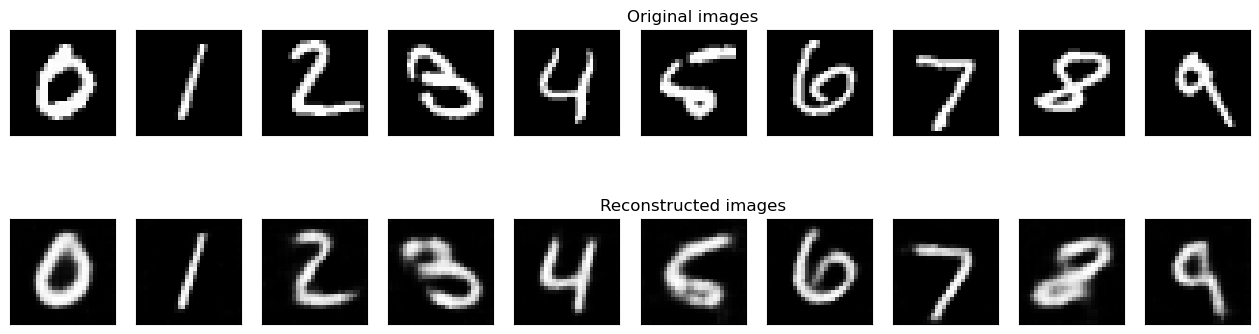


 EPOCH 27/30 	 train loss 0.01897081732749939 	 val loss 0.019230812788009644

 EPOCH 28/30 	 train loss 0.01891004666686058 	 val loss 0.019166171550750732

 EPOCH 29/30 	 train loss 0.01885473169386387 	 val loss 0.019119465723633766

 EPOCH 30/30 	 train loss 0.018789298832416534 	 val loss 0.01907394826412201


In [44]:
# Train the model
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder, train_loader, loss_fn, optim, device)
    val_loss = test_epoch(encoder,decoder,test_loader,loss_fn, device)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    if epoch % 5 == 0:
        plot_ae_outputs(encoder,decoder,test_dataset=test_dataset, device=device, n=10) 

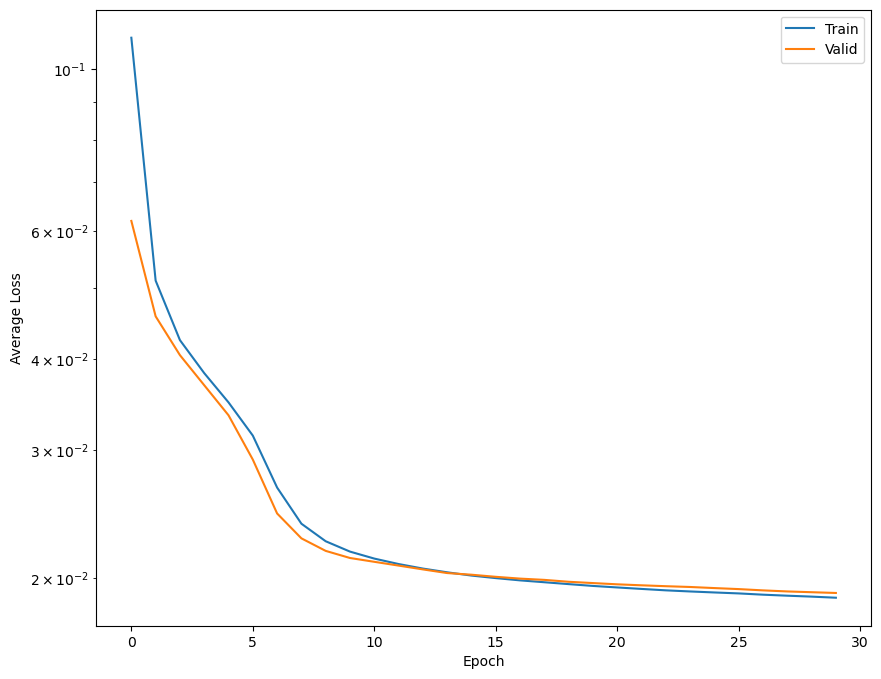

In [45]:
# Plot losses over epochs:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

### Extract latent space representation

In [46]:
# Perform forward pass on test set and subtract latent layer (and labels):
latent_test = []
labels_test = []
for step, (images, labels) in enumerate(test_loader): 
    with torch.no_grad():
        images = images.to(device)
        latent = encoder(images)
    latent_test.extend(latent.cpu().numpy())
    labels_test.extend(labels.cpu().numpy())  
    
# labels_str = list(map(str, labels_test))
    
    
print(f'latent shape: {np.shape(latent_test)}, labels shape: {np.shape(labels_test)}')

latent shape: (10000, 6), labels shape: (10000,)


## Reduce latent space with UMAP

In [47]:
# Fit a (possibly parametric!) UMAP embedding to the latent space representation:
# embedder = ParametricUMAP(n_epochs=50, n_neighbors=20, min_dist=0.1)
embedder = UMAP(n_neighbors=50, min_dist=0.2)
embedding = embedder.fit_transform(latent_test)

### Question - can you "train" UMAP on a training set, and then apply the same model to a test set?

Seeing how t-SNE and UMAP iteratively got to their resulting projections, do you think that at the end of the process there is a model, that can be applied to other data? And if not, can you think about, how one could construct a good approximation?

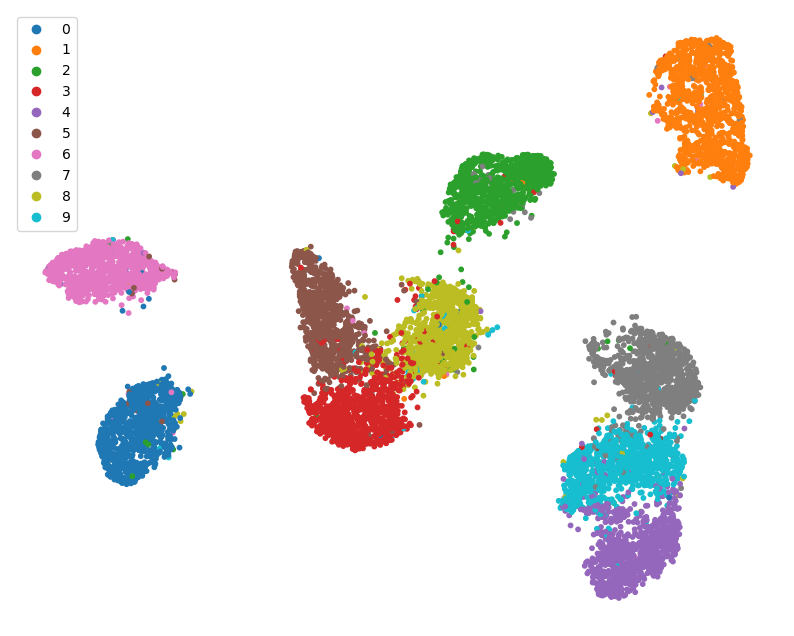

In [48]:
# Plot embedding without example images:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
ax.axis("off");

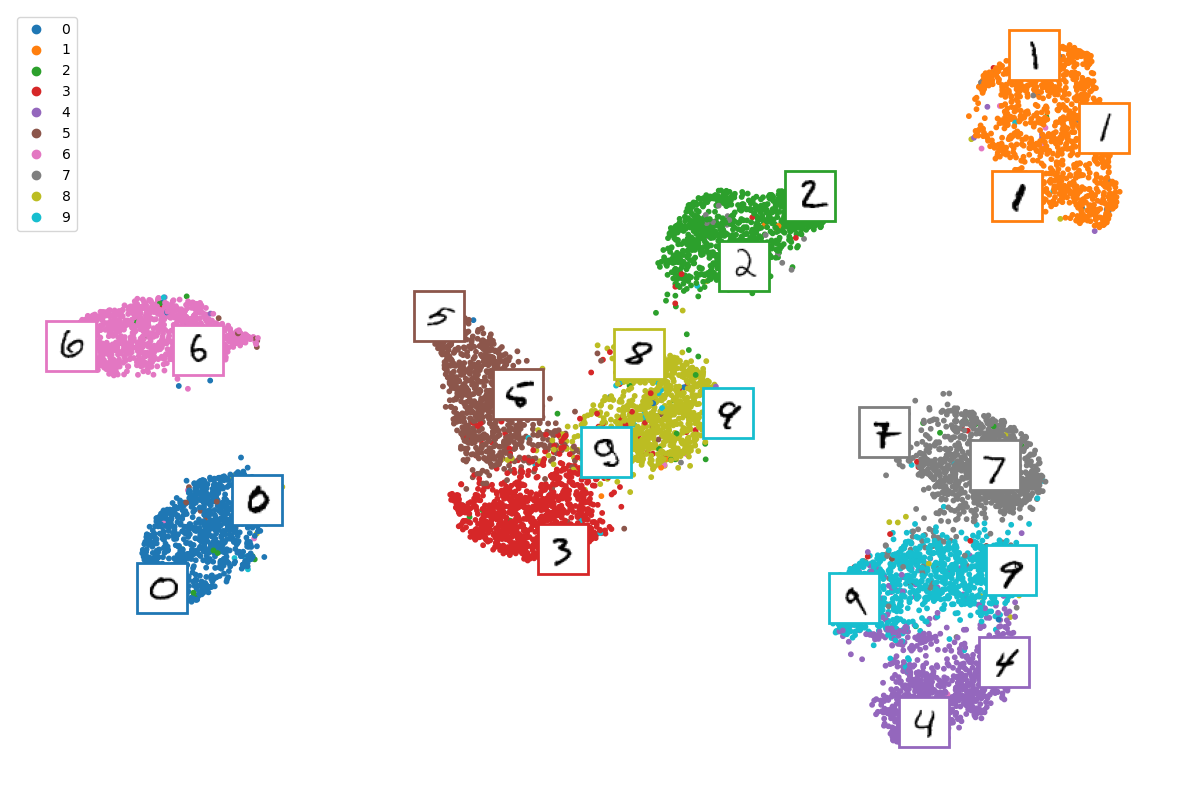

In [49]:
# Plot embedding with example images:
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embedding):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 4:            # If far enough from other images...
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(test_dataset[index][0][0], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels_test[index]), "lw": 2})
        fig.gca().add_artist(imagebox)
ax.axis("off");

In [53]:
# k-means clustering of embedding:
kmeans = KMeans(n_clusters=10, random_state=4)
kmeans.fit(embedding)
clusters = pd.DataFrame(kmeans.labels_, columns=['Cluster'])

classes = np.array(labels_test)
class_names = [0,1,2,3,4,5,6,7,8,9]

clust0 = clusters.loc[clusters['Cluster'] == 0].index.to_numpy()
clust1 = clusters.loc[clusters['Cluster'] == 1].index.to_numpy()
clust2 = clusters.loc[clusters['Cluster'] == 2].index.to_numpy()
clust3 = clusters.loc[clusters['Cluster'] == 3].index.to_numpy()
clust4 = clusters.loc[clusters['Cluster'] == 4].index.to_numpy()
clust5 = clusters.loc[clusters['Cluster'] == 5].index.to_numpy()
clust6 = clusters.loc[clusters['Cluster'] == 6].index.to_numpy()
clust7 = clusters.loc[clusters['Cluster'] == 7].index.to_numpy()
clust8 = clusters.loc[clusters['Cluster'] == 8].index.to_numpy()
clust9 = clusters.loc[clusters['Cluster'] == 9].index.to_numpy()
cluster_list = [clust0, clust1, clust2, clust3, clust4, clust5, clust6, clust7, clust8, clust9]

real_labels = np.concatenate([classes[clust0], classes[clust1], classes[clust2], classes[clust3], classes[clust4], classes[clust5],
                             classes[clust6], classes[clust7], classes[clust8], classes[clust9]])
pred_labels = []

for cluster in cluster_list:
    unique, pos = np.unique(classes[cluster], return_inverse=True)
    maxpos = np.bincount(pos).argmax()
    cluster_label = unique[maxpos]
    for i in range(len(cluster)):
        pred_labels.append(cluster_label)

pred_labels = np.array(pred_labels)

In [51]:
# Function to plot confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          savefig = ''):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.3f}; misclass={misclass:0.3f}', fontsize=16)
    cbar.ax.set_ylabel('Number of items',  labelpad=20, rotation=270, fontsize=16)   
    
    
    if savefig: plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()

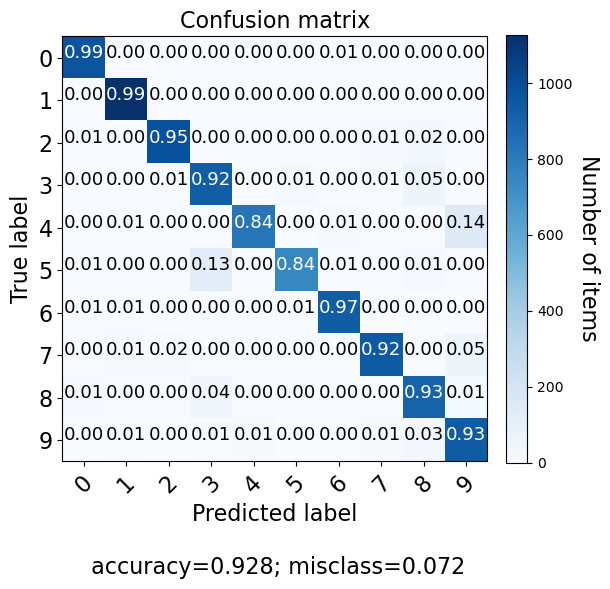

In [54]:
# Plot confusion matrix:
cm = confusion_matrix(real_labels, pred_labels, labels=class_names)
plot_confusion_matrix(cm, target_names=class_names)

### Question - are you satisfied with the confusion matrix?

Is the performance "good enough"? If not, what do you think is the problem, and how could it be solved in a simple manner? And if this is not enough, discuss what else could be done. 

### Final questions - could you learn the number of digits?

Imagine that you didn't know the digits (or something else like zebra calls!), and wanted to estimate this. Can you think of how to do that, and would you be sure to get the right result or a reasonable estimate of it?